In [5]:
#hide
!pip3 install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [6]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [8]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [7]:
subscription_key = "414ae64172a046249ac49b3dc6b71b3e"
search_url = "https://api.bing.microsoft.com/v7.0/images/search"
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

search_term = "grizzly bear"

params  = {"q": search_term, "license": "public", "imageType": "photo"}

response = requests.get(search_url, headers=headers, params=params)
response.raise_for_status()
search_results = response.json()

img_urls = [img['contentUrl'] for img in search_results["value"]]

In [8]:
dest = 'images/grizzly1.jpg'
download_url(img_urls[1], dest, overwrite=true)

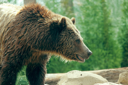

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bear_types = 'black','grizzly','teddy'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        query = o + ' bear'
        params  = {"q": query, "license": "public", "imageType": "photo", "count": 150}
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_results = response.json()
        img_urls = [img['contentUrl'] for img in search_results["value"]]
        #results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=img_urls)

In [12]:
fns = get_image_files(path)
fns

(#363) [Path('bears/grizzly/00000131.jpg'),Path('bears/grizzly/00000065.jpg'),Path('bears/grizzly/00000063.jpg'),Path('bears/grizzly/00000081.jpg'),Path('bears/grizzly/00000050.jpg'),Path('bears/grizzly/00000102.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000016.jpg'),Path('bears/grizzly/00000017.jpeg'),Path('bears/grizzly/00000089.jpg')...]

In [18]:
failed = verify_images(fns)
failed

(#4) [Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000143.png'),Path('bears/teddy/00000039.jpg'),Path('bears/black/00000113.jpg')]

In [19]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [20]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
dls = bears.dataloaders(path)

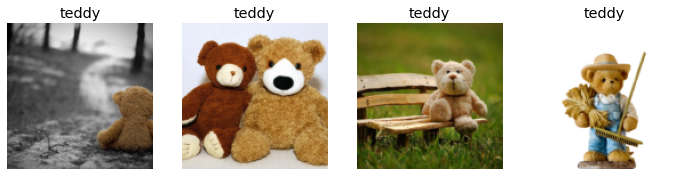

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

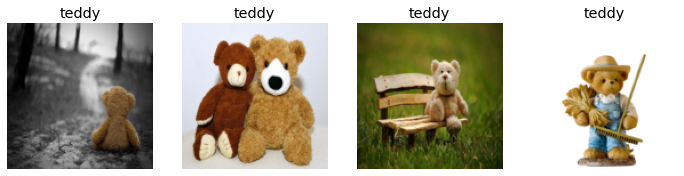

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

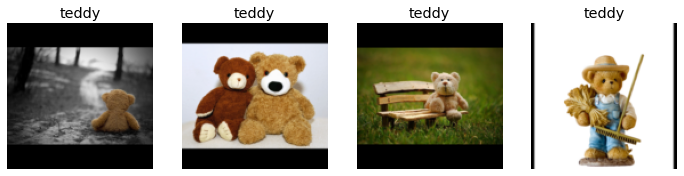

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

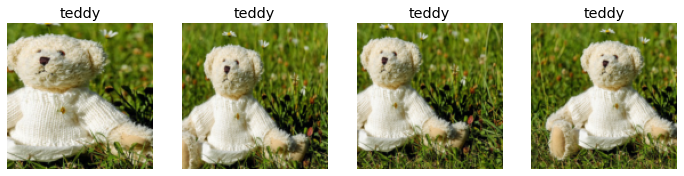

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

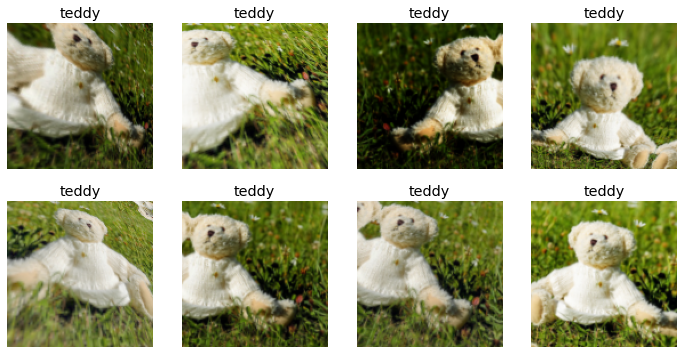

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [22]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.492248,0.523442,0.154930,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.599758,0.258887,0.070423,00:11
1,0.488563,0.228304,0.070423,00:11
2,0.415425,0.273587,0.098592,00:10
3,0.367961,0.283958,0.084507,00:11


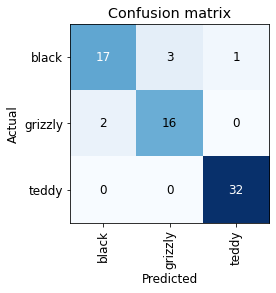

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

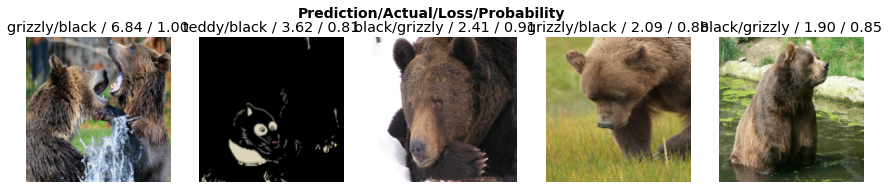

In [25]:
interp.plot_top_losses(5, nrows=1)

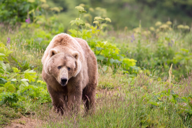

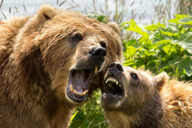

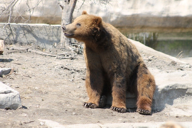

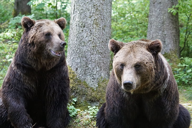

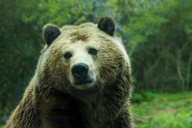

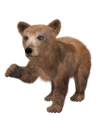

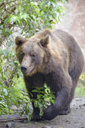

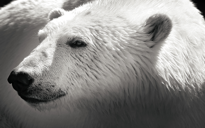

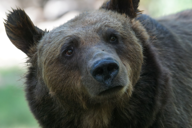

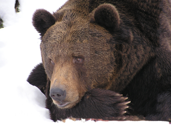

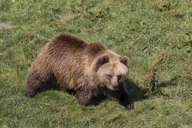

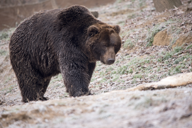

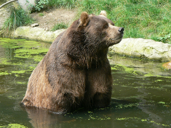

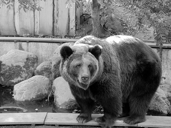

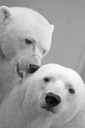

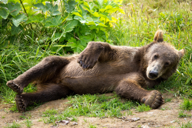

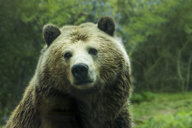

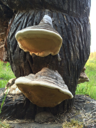

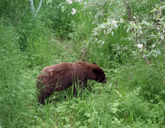

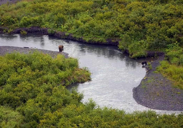

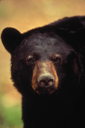

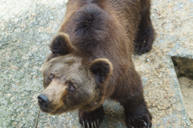

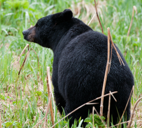

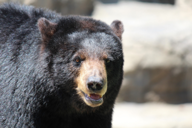

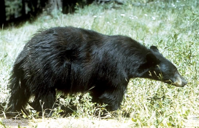

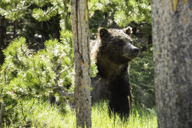

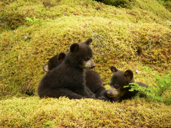

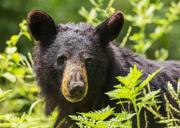

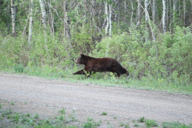

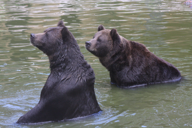

In [29]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [1]:
learn.export()

NameError: name 'learn' is not defined

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
learn_inf.predict('images/grizzly1.jpg')

('grizzly', TensorImage(1), TensorImage([8.7454e-05, 9.9991e-01, 1.2358e-07]))

In [28]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly1.jpg'])

In [31]:
img = PILImage.create(btn_upload.data[-1])

In [32]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [33]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9999')

In [37]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

IndexError: list index out of range

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

- Most images uploaded to the internet show a perfect picture of a bear so it might not be good at detecting bears behind a bush or around trees

2. Where do text models currently have a major deficiency?

- Models are not good at generating correct responses, but are good at classifying documents as spam or not, or context appropiate text such as social media posts

3. What are possible negative societal implications of text generation models?

- Text generation on social media to sperad disinformation or social unrest

4. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?

- Having a human monitor the model before releasing it fully

5. What kind of tabular data is deep learning particularly good at?

- High cardinality columns (something that contains a large number of discrete choices such as. zip code or product ID)

6. What's a key downside of directly using a deep learning model for recommendation systems?

- They tell you things the customer might like instead of something useful to the customer. Ex. If you buy books from a specific author on amazon they will just reccomend more books but that author.

7. What are the steps of the Drivetrain Approach?

- Consider the objective, then consider that actions you can take to meet the objective and what data you need that will help, then build a model that can be used to determine the best actions to get the best results 

8. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.

- Will do.

9. What is `DataLoaders`?

- Class that stores whatever Dataloader you pass to it. Makes the data available as train and validation sets

10. What four things do we need to tell fastai to create `DataLoaders`?

- We need to create a DataBlock and we define the blocks (parameters being passed in, images and labels), get_items, splitter, item_tfms

11. What does the `splitter` parameter to `DataBlock` do?

- Splitter splits your data into train and validation
- Random splitter choices random images from your set but in practice it is good to use the last portion

12. How do we ensure a random split always gives the same validation set?

- Through passing the same seed to the splitter

13. What letters are often used to signify the independent and dependent variables?

- Independant as x and dependant as y

14. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

- Squish squishes the image, pad provides some padding (black space) around the image

15. What is data augmentation? Why is it needed?

- Creates random variations of your images, this provides more data to learn form 

16. What is the difference between `item_tfms` and `batch_tfms`?

- item-trms transforms all the images where batch changes 

17. What is a confusion matrix?

- A confusion matrix is used to see how well your model did,
  shows correct and incorrect predictions

18. What does `export` save?

- export saves the model you created

19. What is it called when we use a model for getting predictions, instead of training?

- Inference

20. What are IPython widgets?

- GUI widgets made in python

21. When might you want to use CPU for deployment? When might GPU be better?

- When you are just running inference against your model it might be good to use the cpu or when you are just getting started, gpu will be better for training or if you are doing things at a larger scale

22. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?

- App needs network connection, requires sending user data to a server

23. What are three examples of problems that could occur when rolling out a bear warning system in practice?

- Might not be handling night time recognition, low resolution cameras, might not be good at detecting bears in the forest

24. What is "out-of-domain data"?

- Data which model sees in production that is much different from what it saw during training

25. What is "domain shift"?

- The type of data that our model sees changes over time

26. What are the three steps in the deployment process?

- Manuel process, limited scope deployment, gradual expansion

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.